In [1]:
# Run to load packages
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

## Introduction:
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

## Predicting the amount of money received by players based on their rank

Tennis is a popular sport among men and women all over the world. Therefore, the analysis of factors affecting performance and success is of great interest. Since tennis players' earnings can vary widely and "Prize Money” could reflect a player's earnings in tennis tournaments, understanding the determinants of prize money can provide insights into the financial success of professional tennis players. One main factor is ranking points. In professional tennis, players compete in various tournaments, accumulate ranking points, and move up or down in the rankings based on their performance. This system is used to determine tournament entries and player recognition. 

In our model, our research question is "How can we use ranking points to predict the prize money a tennis player receives?" To answer the question, we will be using the data `player_stats(1).csv` from Ultimate Tennis Statistics. This data set contains the statistics of the top 500 tennis players in the world. Run the next cell to load in the data.

In [2]:
# run to load data set
player_data <- read_csv("https://raw.githubusercontent.com/dcai01/dsci100_project/main/project_proposal/data/player_stats%20(1).csv")
head(player_data)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Methods & Results:
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
    - note: all tables and figure should have a figure/table number and a legend


Starting off, we are going to clean and wrangle our data. Run the next cell tidy up the data.

In [3]:
set.seed(1000)
# Run to view tidied/wrangled data
player_data$"Prize Money" <- gsub("[^0-9.-]", "", player_data$"Prize Money")

player_data_renamed <- player_data |>
    separate(Age, into = c("age", "birthday"), sep ="\\(") |>
    separate("Best Rank", into = c("best_rank", "date"), sep ="\\(") |>
    separate("Current Rank", into = c("current_rank", "points"), sep ="\\(") |>
    separate("Prize Money", into = c("prize_money", "dash"), sep = "-")|>
    rename(plays = Plays, backhand = Backhand, name = Name)|>
    select(name, age, plays, current_rank, best_rank, backhand, prize_money) |>
    drop_na()

player_data_renamed$plays_dummy <- ifelse(player_data_renamed$plays == "Right-handed", 1, 0) #1 means "Right-handed" and 0 means "Left-handed	
player_data_renamed$backhand_dummy <- ifelse(player_data_renamed$backhand == "One-handed", 1, 0) #1 means "One-handed	" and 0 means "Two-handed"

player_data_renamed <- player_data_renamed |>
                       mutate(age = as.numeric(age),
                              current_rank = as.numeric(current_rank),
                              best_rank = as.numeric(best_rank),
                              prize_money = as.numeric(prize_money))
head(player_data_renamed)

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 399 rows [2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, ...].”


name,age,plays,current_rank,best_rank,backhand,prize_money,plays_dummy,backhand_dummy
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Jack Draper,18,Left-handed,326,316,Two-handed,59040,0,0
Lukas Lacko,32,Right-handed,178,44,Two-handed,3261567,1,0
Duck Hee Lee,21,Right-handed,236,130,Two-handed,374093,1,0
Bernard Tomic,27,Right-handed,183,17,Two-handed,6091971,1,0
Hubert Hurkacz,22,Right-handed,31,31,Two-handed,1517157,1,0
Sekou Bangoura,28,Right-handed,307,213,Two-handed,278709,1,0


Before we start our regression analysis, we want to pick which variable we will use from the tidied data. We decided to use the variables: `age`, `current_rank`, `best_rank`, `prize_money`, `plays_dummy`, and `backhand_dummy`. Run the cell below to select the columnms we are interested in using for our analysis into `player_data_selected`.

In [18]:
player_data_selected<-as_tibble(player_data_renamed)|>
                    select(age, current_rank, best_rank, prize_money, plays, plays_dummy, backhand_dummy) 
head(player_data_selected)

age,current_rank,best_rank,prize_money,plays,plays_dummy,backhand_dummy
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
18,326,316,59040,Left-handed,0,0
32,178,44,3261567,Right-handed,1,0
21,236,130,374093,Right-handed,1,0
27,183,17,6091971,Right-handed,1,0
22,31,31,1517157,Right-handed,1,0
28,307,213,278709,Right-handed,1,0


Our main independent variable are `best_rank` and `current_rank`; 
`best_rank` represents a player's the highest rank they have achieved. It is crucial to consider this variable as it can impact a player's reputation, endorsements, and invitations to play in future prestige tournaments. The `best_rank` variable also provides insight into a player's playing history, which shows the challenges they faces or if they are on an upward trajectory. `current_rank` represents a tennis player's current rank. By analyzing the current ranks of players, it allows us to analyze how their ranking point may affect their progress; having a higher current rank will allow tennis players an opportunity to enter more honored tournaments, which will impact the amount of prize money they will earn. The independent variables are both crucial to analyze our problem because of a player has a higher rank, the amount of prize money they will receive may vary. 

Our control variables are `age`, `plays_dummy` (their playing hand), and `backhand_dummy` (the use of backhand plays). These variables were chosen as they may all lead to changes of our dependent variable,`prize_money`.
`age` is important since younger players may have more energy and stamina, potentially providing them with a competitive advantage. On the other hand, older players may have the experience and strategic depth, but their physical condition may decline. As for `plays_dummy` and `backhand_dummy`, these variables represent if they play plays with their left or right hand. Dominant hand and the choice of backhand style can impact a player's style and game strategy, which might be reflected in their prize earnings. We transformed the qualitative variables to its respective dummy variables, 1 is for right handed while 0 is for left handed. All of these variables provide different dimensions of a player's career and can help create a more accurate model.


Before we perform our exploratory data analysis, we are going to create our training and testing data sets. Our training data will be called `player_train` and our testing data will be called `player_test`.

In [19]:
# Run to split data into training and testing set
player_split <- initial_split(player_data_selected, prop = 0.75, strata = prize_money)
player_train <- training(player_split)
player_test <- testing(player_split)

Next, we are summarizing the player data into its mean values (`player_summarize_mean`), maximum values (`player_summarize_max`), and minimum values (`player_summarize_min`). After performing the summarization of our player data, we are merging the data together by Variables (i.e. backhand, age, rank, etc.) into `player_summarize_data`.

In [27]:
# Run to calculate mean, max and min of each variable
player_summarize_mean <- player_train |>
                        select(-plays)|>
                        map_dfr(mean, na.rm = TRUE) |>
                        round(1) |>
                         pivot_longer(
                          cols = age:backhand_dummy,
                          names_to = "Variable",
                          values_to = "Mean")

                        
player_summarize_max <- player_train |>
                        select(-plays)|>
                        map_dfr(max, na.rm = TRUE)|>
                        pivot_longer(
                        cols = age:backhand_dummy,
                        names_to = "Variable",
                        values_to = "Max")

player_summarize_min <- player_train |>
                        select(-plays)|>
                        map_dfr(min, na.rm = TRUE)|>
                        pivot_longer(
                        cols = age:backhand_dummy,
                        names_to = "Variable",
                        values_to = "Max") 
# Do we need plauer_summarize_min because we dont use it for any other codes.

player_summarize_data = merge(player_summarize_mean, player_summarize_max, by = "Variable")


player_summarize_data

Variable,Mean,Max
<chr>,<dbl>,<dbl>
age,26.3,40
backhand_dummy,0.1,1
best_rank,143.4,485
current_rank,216.3,500
plays_dummy,0.9,1
prize_money,94664439.0,2746601610


From the summarization of the variables, it allows us to analyze the average and maximum of each variable. For `age`, the average age of tennis players is 26 years old, while the oldest player in this trained data set is 40. The average `best_rank` is 143th place, with the lowest best rank being 485th place. the `current_rank` of this data set is averaged to be lower, with a rank of 216th as its average and the lowest current rank being 500th. With this analysis, we summarized that the average player prize money being $\$ $94664439, with the largest amount of money received being $\$ $2746601610



Warning message:
“Removed 73 rows containing missing values (`geom_point()`).”


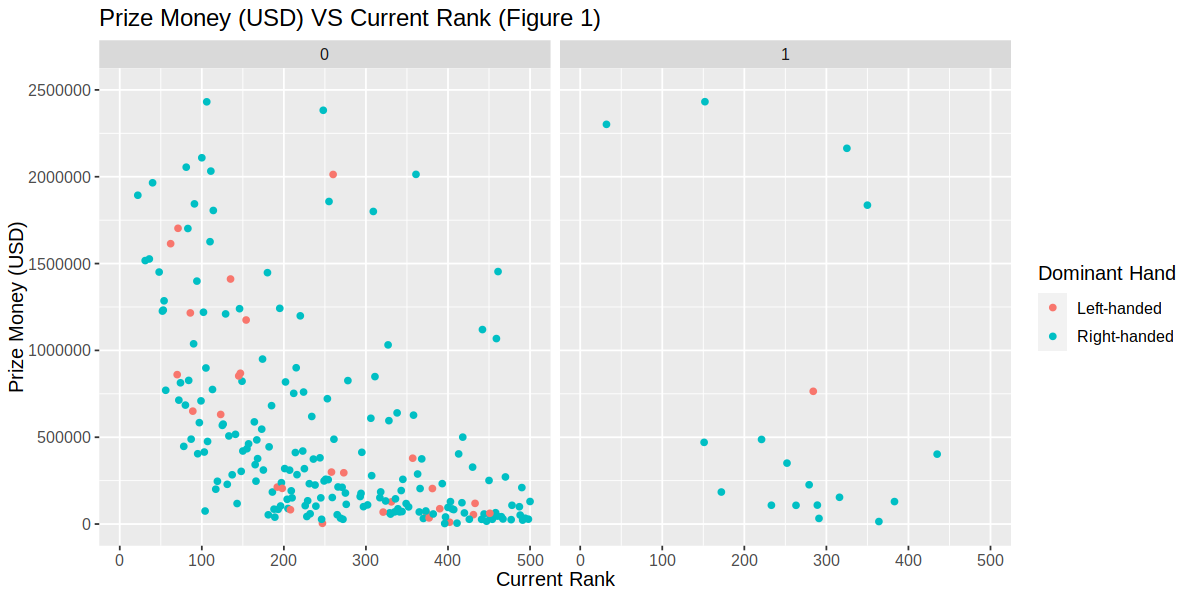

In [33]:
# Run to see plot comparing prize money and current rank

options(repr.plot.width = 10, repr.plot.height = 5) 
small_plot_current <- ggplot(player_train, aes(x = current_rank, y = prize_money, color = plays)) +
  geom_point() +
  xlab("Current Rank") +
  xlim(0, 500) +
  ylim(0, 2500000) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant Hand") +
  theme(text = element_text(size = 12)) +
  facet_grid(cols = vars(backhand_dummy)) +
  ggtitle("Prize Money (USD) VS Current Rank (Figure 1)")

small_plot_current

#Figure 1

Warning message:
“Removed 73 rows containing missing values (`geom_point()`).”


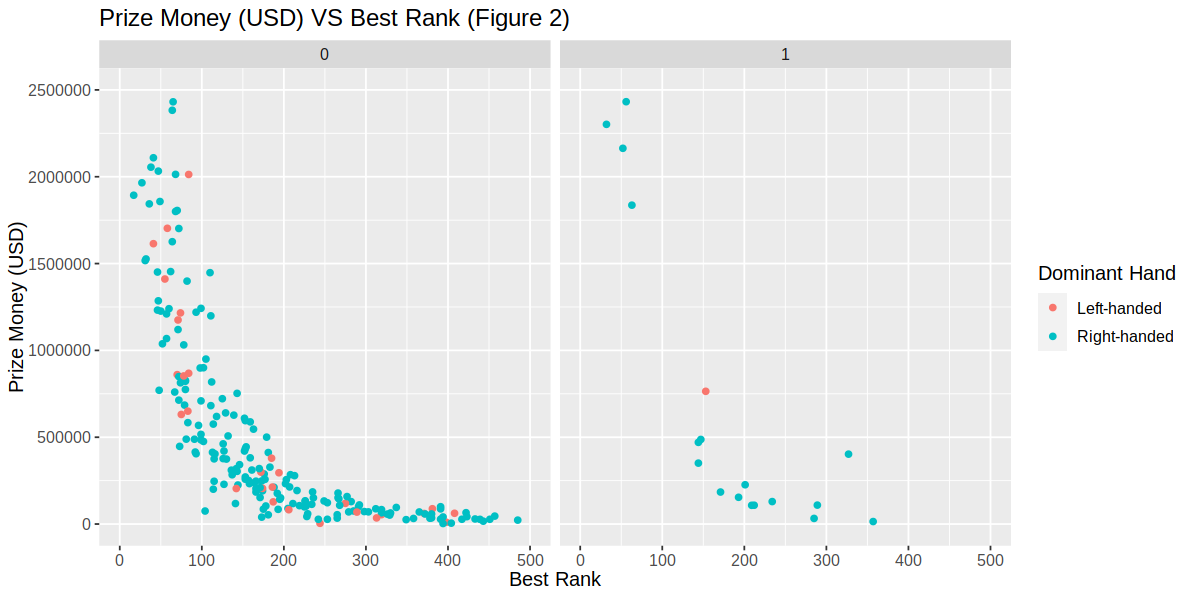

In [34]:
# Run to see plot comparing prize money and best rank 

options(repr.plot.width = 10, repr.plot.height = 5) 
small_plot_best <- ggplot(player_train, aes(x = best_rank, y = prize_money, color = plays)) +
  geom_point() +
  xlab("Best Rank") +
  xlim(0, 500) +
  ylim(0, 2500000) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant Hand") +
  facet_grid(cols = vars(backhand_dummy)) +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Best Rank (Figure 2)")

small_plot_best


Warning message:
“Removed 73 rows containing missing values (`geom_point()`).”


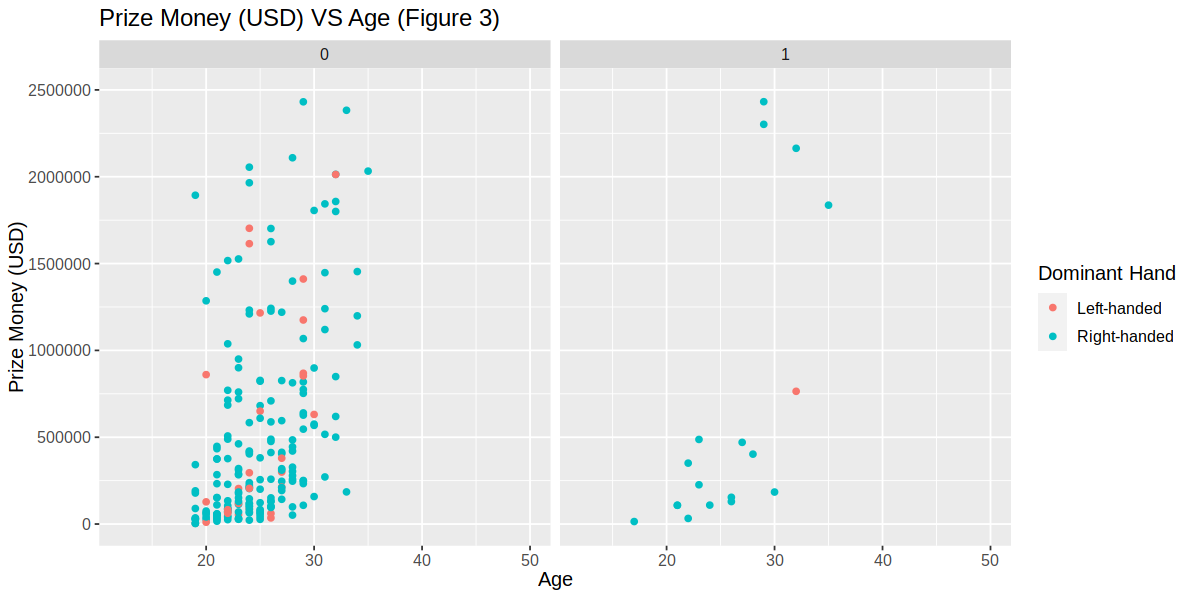

In [35]:
# Run to see plot comparing prize money and age

options(repr.plot.width = 10, repr.plot.height = 5) 
small_plot_age <- ggplot(player_train, aes(x = age, y = prize_money, color = plays)) +
  geom_point() +
  xlab("Age") +
  xlim(12, 50) +
  ylim(0, 2500000) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant Hand") +
  facet_grid(cols = vars(backhand_dummy)) +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Age (Figure 3)")


small_plot_age

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 73 rows containing non-finite values (`stat_boxplot()`).”


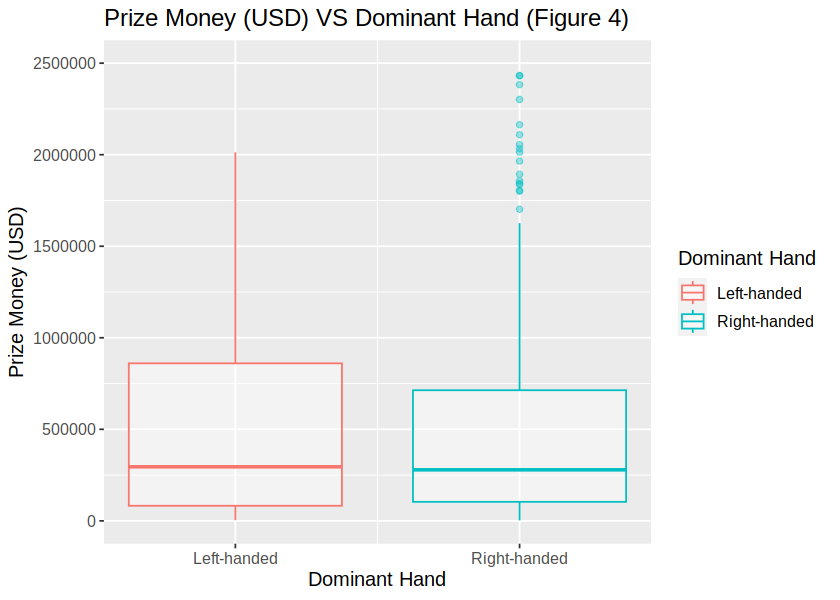

In [36]:
# Run to see plot comparing prize money and dominant hand

options(repr.plot.width = 7, repr.plot.height = 5) 
small_plot_hand <- ggplot(player_train, aes(x = plays_dummy, y = prize_money, color = plays)) +
  geom_boxplot(alpha=0.4) +
  xlab("Dominant Hand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Left-handed", "Right-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant Hand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Dominant Hand (Figure 4)")

small_plot_hand

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 73 rows containing non-finite values (`stat_boxplot()`).”


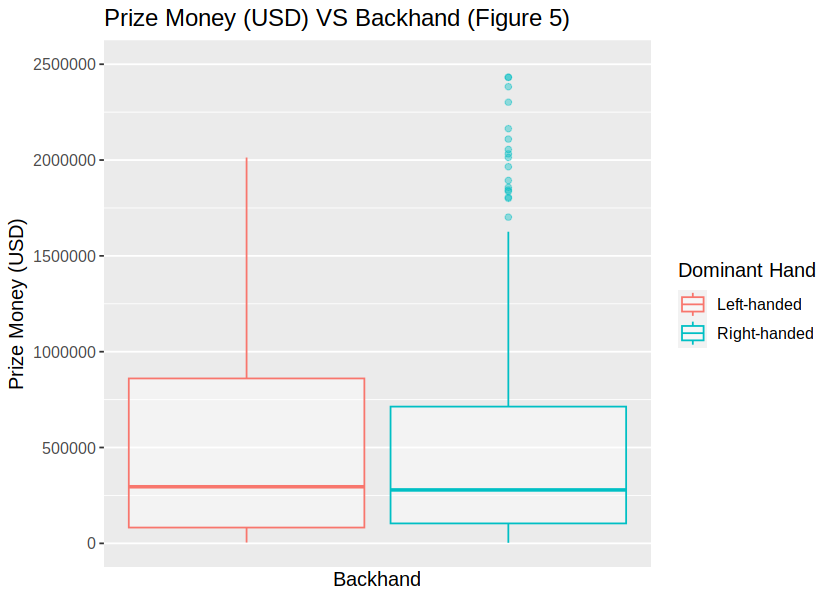

In [37]:
# Run to see plot comparing prize money and backhand

options(repr.plot.width = 7, repr.plot.height = 5) 
small_plot_backhand <- ggplot(player_train, aes(x = backhand_dummy, y = prize_money, color = plays)) +
  geom_boxplot(alpha=0.4) +
  xlab("Backhand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Two-handed", "One-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant Hand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Backhand (Figure 5)")

small_plot_backhand

## Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.